# LSTM 모델 테스트 - 산업용
---

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Dropout
from keras.losses import Huber
from keras.optimizers import Adam

## [1] 데이터 로딩
---

In [71]:
data = pd.read_csv("data_tomato.csv", index_col=0)
target = pd.read_csv("target.csv", index_col=0)

In [72]:
data.head()

,TCL_AT,TCL_LT,TCL_HT,TEMP_EF_CAP,TEMP_EF_DONGNAM,TEMP_EF_DAEGYUNG,TEMP_EF_CHOONG,TEMP_EF_HONAM,TEMP_EF_MEAN,POWER_WATER,...,POWER_LNG,ELEC_ALL,ELEC_FAMILY,ELEC_PUBLIC,ELEC_SERVICE,ELEC_CIVIL_SUM,ELEC_ARGRI_FISHING,ELEC_MINING,ELEC_MANUFACT,ELEC_INDSUM
DATE,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.004764,-0.189311,0.240528,0.84711,5.91778,6.73765,3.33479,1.88651,3.744768,363291,...,233891.0,16224867,2814138,557379,3616542,6988059,301811,80421,8854576,9236808
1996-02-01,0.007708,-0.226982,0.372691,0.81430,5.90875,6.73291,3.32638,1.87883,3.732234,356379,...,233891.0,15363840,2788312,558610,3551611,6898533,327617,70471,8067220,8465308
1996-03-01,0.137972,-0.045631,0.367739,0.60731,5.81529,6.67634,3.22000,1.78740,3.621268,362980,...,233891.0,16094268,2555048,528672,3333225,6416945,345359,81877,9250086,9677322
1996-04-01,0.261910,0.029456,0.582132,0.24132,5.71003,6.61264,3.07795,1.66054,3.460496,367415,...,233891.0,16266027,2629204,555354,3430624,6615182,292235,84596,9274014,9650845
1996-05-01,0.428759,0.242892,0.688458,-0.38328,5.67433,6.58956,3.02586,1.62083,3.305460,440662,...,233891.0,16028072,2525076,511468,3333483,6370027,302913,80963,9274169,9658045


In [73]:
target.head()

,CIVIL,IND
DATE,,
1996-01-01,605519,83809
1996-02-01,566323,70427
1996-03-01,477514,62652
1996-04-01,337797,47050
1996-05-01,184522,30709


## [2] 데이터 전처리
---

### [2-1] 데이터 정규화

In [74]:
scaler = MinMaxScaler()
scale_cols = list(data.columns)

scaled = scaler.fit_transform(data)

data_scaled = pd.DataFrame(scaled, columns=scale_cols)
data_scaled.head()

target_ind = scaler.fit_transform(pd.DataFrame(target["IND"]))

### [2-2] 데이터 분할

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    data_scaled, target_ind, shuffle=False, test_size=0.2, random_state=42
)

In [76]:
print(X_train.shape, y_train.shape)

(240, 29) (240, 1)


In [77]:
print(X_test.shape, y_test.shape)

(60, 29) (60, 1)


### [2-3] 시퀀스 데이터셋 구성

In [78]:
def windowed_dataset(X, y, window_size, batch_size, shuffle):
    # X 값 window dataset 구성
    X_ds = tf.data.Dataset.from_tensor_slices(X)
    X_ds = X_ds.window(window_size, shift=1, stride=1, drop_remainder=True)
    X_ds = X_ds.flat_map(lambda x: x.batch(window_size))
    # y 값 추가
    y_ds = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((X_ds, y_ds))
    if shuffle:
        ds = ds.shuffle(80)
    return ds.batch(batch_size).prefetch(1)

In [79]:
WINDOW_SIZE = 4
BATCH_SIZE = 32

train_data = windowed_dataset(X_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(X_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [80]:
for data in train_data.take(1):
    print(data[0].shape)

(32, 4, 29)


## [3] 모델 생성
---

In [90]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=[WINDOW_SIZE, 29]),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    LSTM(64),
    Dropout(0.25),
    Dense(32, activation="relu"),
    Dropout(0.25),
    Dense(1)
])

loss = Huber()
optimizer = Adam(0.0005)

model.compile(optimizer=optimizer, loss=loss, metrics="mse")
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 2, 32)             2816      
                                                                 
 lstm_19 (LSTM)              (None, 2, 64)             24832     
                                                                 
 dropout_18 (Dropout)        (None, 2, 64)             0         
                                                                 
 lstm_20 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_20 (Dropout)        (None, 32)              

In [91]:
model.fit(
    train_data,
    epochs=50
)

Epoch 1/50
8/8 [==============================] - 2s 8ms/step - loss: 0.0716 - mse: 0.1433
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0356 - mse: 0.0713
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - mse: 0.0308
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - mse: 0.0348
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - mse: 0.0321
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0140 - mse: 0.0280
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0127 - mse: 0.0253
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0102 - mse: 0.0204
Epoch 9/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0088 - mse: 0.0177
Epoch 10/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0085 - mse: 0.0169
Epoch 11/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0081 - mse: 0.01

In [92]:
pred = model.predict(test_data)

2/2 [==============================] - 0s 19ms/step


In [93]:
pred.shape

(56, 1)

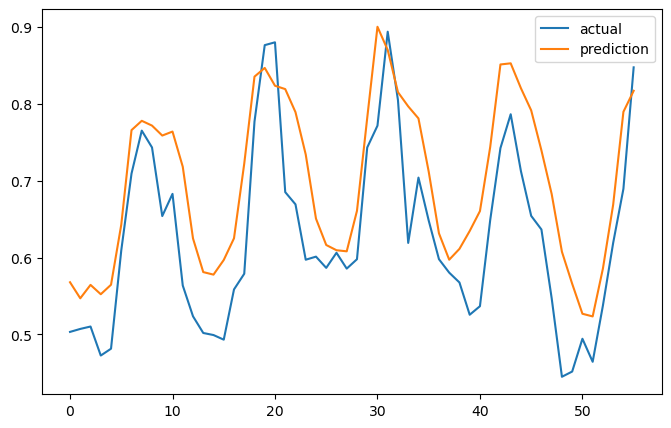

In [95]:
plt.figure(figsize=(8, 5))
plt.plot(np.asarray(y_test)[4:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()